# Data loading

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
import numpy as np
import os
import warnings

# For progress bar
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable, desc=""):
        return iterable

# ---------------------------------------------------------------------
# 1) Configuration / Setup
# ---------------------------------------------------------------------

# 1a) Suppress warnings
warnings.filterwarnings(
    "ignore",
    message="The number of bins estimated may be suboptimal."
)
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message="DataFrameGroupBy.apply operated on the grouping columns"
)

# 1b) Instrument, file patterns, output directory
instr = 'xrt'
os.makedirs(f"plots/{instr}", exist_ok=True)

file_pattern_full = (
    f'/disk/data/youssef/scripts/xrb-population/results_latest/{instr}_results/*full*.csv'
)
file_pattern_agg  = (
    f'/disk/data/youssef/scripts/xrb-population/results_latest/{instr}_results/*.csv'
)

# Identify the files
csv_files_full = [f for f in glob(file_pattern_full)]
csv_files_agg  = [f for f in glob(file_pattern_agg) if "full" not in f]

# The columns we ultimately want in the aggregated file
all_needed_cols = [
    "red_chi_squared", "gamma", "temp", "power_norm_fit",
    "disk_norm_fit", "total_flux_median", "d_fit_median",
    "d_fit_peak", "peak_flux", "d_fit_weighted_median",
    "error_d_median", "frac_uncert_median", "error_d_peak",
    "frac_uncert_peak"
]

# This is the central column (distance statistic) used for filtering
central_value = "d_fit_weighted_median"

# ---------------------------------------------------------------------
# 2) Global Data Structures
# ---------------------------------------------------------------------
# Same structures from your original script
distances       = []
na_distances    = []
tight_distances = []
na_nH           = []
all_data        = []
na_d_fit_files  = []
na_d_fit_params = []
all_data_params = []

# ---------------------------------------------------------------------
# 3) Helper Functions
# ---------------------------------------------------------------------
def extract_parameters(filename):
    """
    Extract parameter values (g, T, a, m, i, r, e) from the filename 
    using regular expressions. Adjust the pattern to match your filenames.
    """
    pattern = (
        r'table_g(?P<g>\d+\.\d+)_T(?P<T>\d+\.\d+)_a(?P<a>\d+\.\d+)_'
        r'm(?P<m>\d+\.\d+)_i(?P<i>\d+\.\d+)_r(?P<r>\d+\.\d+)_e(?P<e>\d+\.\d+)'
    )
    match = re.search(pattern, filename)
    if match:
        return {key: float(value) for key, value in match.groupdict().items()}
    else:
        return None

def calc_MAE(scale, l_err, u_err):
    """
    Calculate Mean Absolute Error (MAE) and safeguard reciprocal weight calculation.

    Parameters:
        scale (float): The scaling factor for error normalization.
        l_err (numpy.ndarray): Lower error values.
        u_err (numpy.ndarray): Upper error values.

    Returns:
        numpy.ndarray: The computed MAE array with safeguards.
    """
    # Check that l_err and u_err are of the same length
    if len(l_err) != len(u_err):
        raise ValueError("`l_err` and `u_err` must have the same length.")
    
    # Ensure no negative or zero error intervals
    error_diff = u_err - l_err
    if np.any(error_diff <= 0):
        warnings.warn(
            f"Non-positive error intervals detected: {error_diff[error_diff <= 0]} ... {u_err[error_diff <= 0]} ... {l_err[error_diff <= 0]} will take absolute of the difference")
    
    # Calculate MAE
    mae = (error_diff / 2) / scale

    # Check for invalid or NaN results
    if np.any(np.isnan(mae)):
        raise ValueError("MAE calculation resulted in NaN values.")
    
    return np.abs(mae)


def weighted_median(values, weights):
    """
    Compute the weighted median of a 1D NumPy array `values` 
    with positive `weights`.

    Parameters:
        values (numpy.ndarray): Array of data values.
        weights (numpy.ndarray): Array of weights corresponding to `values`.

    Returns:
        float or None: The weighted median, or None if inputs are invalid.
    """
    # Input validation
    if not isinstance(values, np.ndarray) or not isinstance(weights, np.ndarray):
        raise TypeError("Both `values` and `weights` must be NumPy arrays.")
    if values.ndim != 1 or weights.ndim != 1:
        raise ValueError("Both `values` and `weights` must be 1D arrays.")
    if len(values) == 0:
        raise ValueError("`values` array cannot be empty.")
    if len(values) != len(weights):
        raise ValueError("`values` and `weights` must have the same length.")
    if np.any(weights < 0):
        raise ValueError(f"`weights` must contain only non-negative values. {weights[weights < 0]}")
    if np.any(np.isnan(weights)):
        raise ValueError("`weights` cannot contain NaN values.")
    if np.sum(weights) == 0:
        raise ValueError("Sum of `weights` must be greater than zero.")

    # Sort values and weights by `values`
    sort_idx = np.argsort(values)
    sorted_values = values[sort_idx]
    sorted_weights = weights[sort_idx]

    # Compute cumulative weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    midpoint = 0.5 * total_weight

    # Find the index where cumulative weight crosses the midpoint
    median_idx = np.searchsorted(cumulative_weights, midpoint, side='right')

    return sorted_values[median_idx]

def find_peak(array):
    """
    Find the peak (mode) of the distribution by computing a histogram.
    The bin size uses 'stone' by default. Adjust if needed.
    """
    if len(array) == 0:
        return None
    counts, bins = np.histogram(array, bins='stone')
    peak_idx = np.argmax(counts)
    return 0.5 * (bins[peak_idx] + bins[peak_idx + 1])

# ---------------------------------------------------------------------
# 4) Function to compute ALL columns
# ---------------------------------------------------------------------
def compute_all_stats(df):
    """
    Compute all columns for each group (nH, d).
    """
    nH_val = df['nH'].iloc[0] if 'nH' in df.columns else None
    d_val  = df['d'].iloc[0]  if 'd'  in df.columns else None

    d_fit_peak = find_peak(df['d_fit'].dropna()) if 'd_fit' in df.columns else None
    total_flux_peak = find_peak(df['total_flux'].dropna()) if 'total_flux' in df.columns else None

    if {'d_fit', 'error_d_low', 'error_d_up'}.issubset(df.columns):
        valid_mask = (
            df['d_fit'].notna() &
            df['error_d_low'].notna() &
            df['error_d_up'].notna()
        )
        if valid_mask.any():
            w = 1 / calc_MAE(
                df.loc[valid_mask, 'd_fit'],
                df.loc[valid_mask, 'error_d_low'],
                df.loc[valid_mask, 'error_d_up']
            )
            d_fit_weighted_med = weighted_median(
                df.loc[valid_mask, 'd_fit'].values,
                w.values
            )
        else:
            d_fit_weighted_med = None
    else:
        d_fit_weighted_med = None

    if d_fit_peak is not None and d_val is not None:
        peak_dist_err = d_fit_peak - d_val
        frac_peak_err = peak_dist_err / d_val if d_val != 0 else None
    else:
        peak_dist_err = None
        frac_peak_err = None

    if 'd_fit' in df.columns and df['d_fit'].notna().any() and d_val is not None:
        d_fit_median = df['d_fit'].median()
        error_d_median = d_fit_median - d_val
        frac_uncert_median = (
            error_d_median / d_val 
            if d_val != 0 else None
        )
    else:
        d_fit_median = None
        error_d_median = None
        frac_uncert_median = None

    return pd.Series({
        "nH": nH_val,
        "d": d_val,

        "red_chi_squared": df['red_chi_squared'].median() if 'red_chi_squared' in df.columns else None,
        "gamma": df['gamma'].median() if 'gamma' in df.columns else None,
        "temp": df['temp'].median() if 'temp' in df.columns else None,

        "power_norm_fit": df['power_norm_fit'].median() if 'power_norm_fit' in df.columns else None,
        "disk_norm_fit": df['disk_norm_fit'].median() if 'disk_norm_fit' in df.columns else None,
        "total_flux_median": df['total_flux'].median() if 'total_flux' in df.columns else None,

        "d_fit_median": d_fit_median,
        "d_fit_peak": d_fit_peak,
        "peak_flux": total_flux_peak,
        "d_fit_weighted_median": d_fit_weighted_med,

        "error_d_median": error_d_median,
        "frac_uncert_median": frac_uncert_median,
        "error_d_peak": peak_dist_err,
        "frac_uncert_peak": frac_peak_err
    })

# ---------------------------------------------------------------------
# 5) Function to compute ONLY a subset of columns
# ---------------------------------------------------------------------
def compute_subset_stats(df, needed_cols):
    """
    Compute only the columns in `needed_cols` for each group (nH, d).
    Return them plus (nH, d).
    """
    nH_val = df['nH'].iloc[0] if 'nH' in df.columns else None
    d_val  = df['d'].iloc[0]  if 'd'  in df.columns else None

    result = {
        "nH": nH_val,
        "d": d_val,
    }

    # Example logic for 'd_fit_peak', 'error_d_peak', 'frac_uncert_peak'
    if "d_fit_peak" in needed_cols or "error_d_peak" in needed_cols or "frac_uncert_peak" in needed_cols:
        d_fit_peak = find_peak(df['d_fit'].dropna()) if 'd_fit' in df.columns else None
        if "d_fit_peak" in needed_cols:
            result["d_fit_peak"] = d_fit_peak
        if d_fit_peak is not None and d_val is not None:
            peak_dist_err = d_fit_peak - d_val
            frac_peak_err = peak_dist_err / d_val if d_val != 0 else None
        else:
            peak_dist_err = None
            frac_peak_err = None
        if "error_d_peak" in needed_cols:
            result["error_d_peak"] = peak_dist_err
        if "frac_uncert_peak" in needed_cols:
            result["frac_uncert_peak"] = frac_peak_err

    if "peak_flux" in needed_cols:
        result["peak_flux"] = find_peak(df['total_flux'].dropna()) if 'total_flux' in df.columns else None

    if "d_fit_weighted_median" in needed_cols:
        if {'d_fit', 'error_d_low', 'error_d_up'}.issubset(df.columns):
            valid_mask = (
                df['d_fit'].notna() &
                df['error_d_low'].notna() &
                df['error_d_up'].notna()
            )
            if valid_mask.any():
                w = 1 / calc_MAE(
                    df.loc[valid_mask, 'd_fit'],
                    df.loc[valid_mask, 'error_d_low'],
                    df.loc[valid_mask, 'error_d_up']
                )
                result["d_fit_weighted_median"] = weighted_median(
                    df.loc[valid_mask, 'd_fit'].values,
                    w.values
                )
            else:
                result["d_fit_weighted_median"] = None
        else:
            result["d_fit_weighted_median"] = None

    if ("d_fit_median" in needed_cols or 
        "error_d_median" in needed_cols or 
        "frac_uncert_median" in needed_cols):
        
        if 'd_fit' in df.columns and df['d_fit'].notna().any() and d_val is not None:
            d_fit_median = df['d_fit'].median()
            error_d_median = d_fit_median - d_val
            frac_uncert_median = (error_d_median / d_val) if d_val != 0 else None
        else:
            d_fit_median = None
            error_d_median = None
            frac_uncert_median = None

        if "d_fit_median" in needed_cols:
            result["d_fit_median"] = d_fit_median
        if "error_d_median" in needed_cols:
            result["error_d_median"] = error_d_median
        if "frac_uncert_median" in needed_cols:
            result["frac_uncert_median"] = frac_uncert_median

    if "red_chi_squared" in needed_cols:
        result["red_chi_squared"] = df['red_chi_squared'].median() if 'red_chi_squared' in df.columns else None

    if "gamma" in needed_cols:
        result["gamma"] = df['gamma'].median() if 'gamma' in df.columns else None

    if "temp" in needed_cols:
        result["temp"] = df['temp'].median() if 'temp' in df.columns else None

    if "power_norm_fit" in needed_cols:
        result["power_norm_fit"] = df['power_norm_fit'].median() if 'power_norm_fit' in df.columns else None

    if "disk_norm_fit" in needed_cols:
        result["disk_norm_fit"] = df['disk_norm_fit'].median() if 'disk_norm_fit' in df.columns else None

    if "total_flux_median" in needed_cols:
        result["total_flux_median"] = df['total_flux'].median() if 'total_flux' in df.columns else None

    return pd.Series(result)

# ---------------------------------------------------------------------
# 6) Main Loop: Only Compute Missing Columns, Collect Data Structures
# ---------------------------------------------------------------------
merged_results = []

for file in tqdm(csv_files_full, desc="Processing FULL CSV Files"):
    # 6a) Extract parameters
    params = extract_parameters(file)
    if params is None:
        continue

    base_name_full = os.path.basename(file)
    base_name_no_ext = os.path.splitext(base_name_full)[0].replace("_full", "")

    # 6b) Attempt to find existing aggregated file
    existing_agg = None
    for f_agg in csv_files_agg:
        if base_name_no_ext in f_agg:
            try:
                existing_agg = pd.read_csv(f_agg)
                break
            except Exception as e:
                print(f"Error reading {f_agg}: {e}")
                existing_agg = None

    # 6c) Load the FULL CSV data
    try:
        full_data = pd.read_csv(file)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # Must have 'nH' and 'd' for grouping
    if 'nH' not in full_data.columns or 'd' not in full_data.columns:
        continue

    # 6d) If no existing aggregated file, compute ALL columns
    if existing_agg is None:
        aggregated_df = (
            full_data
            .groupby(['nH', 'd'], as_index=False)
            .apply(compute_all_stats)
            .reset_index(drop=True)
        )
    else:
        # Identify which columns are missing
        missing_cols = [c for c in all_needed_cols if c not in existing_agg.columns]
        if not missing_cols:
            # Everything is already present
            aggregated_df = existing_agg.copy()
        else:
            # Compute only the missing columns
            partial_agg = (
                full_data
                .groupby(['nH', 'd'], as_index=False)
                .apply(lambda grp: compute_subset_stats(grp, missing_cols))
                .reset_index(drop=True)
            )
            # Merge partial_agg with existing_agg on (nH, d)
            aggregated_df = pd.merge(
                existing_agg,
                partial_agg,
                on=["nH", "d"],
                how="outer",
                suffixes=("_old", "")
            )
            # Fill missing columns from partial_agg
            for col in missing_cols:
                old_col_name = col + "_old"
                new_col_name = col
                if old_col_name in aggregated_df.columns and new_col_name in aggregated_df.columns:
                    # Fill the old column's NaNs with new column's values
                    mask_na = aggregated_df[old_col_name].isna()
                    aggregated_df.loc[mask_na, old_col_name] = aggregated_df.loc[mask_na, new_col_name]
                    # Drop new col, rename old -> col
                    aggregated_df.drop(columns=[new_col_name], inplace=True)
                    aggregated_df.rename(columns={old_col_name: col}, inplace=True)
                elif old_col_name in aggregated_df.columns and new_col_name not in aggregated_df.columns:
                    # The new aggregator didn't produce that col, rename old -> new
                    aggregated_df.rename(columns={old_col_name: col}, inplace=True)

            # Remove leftover columns with _old suffix
            leftover_old = [c for c in aggregated_df.columns if c.endswith("_old")]
            aggregated_df.drop(columns=leftover_old, inplace=True)

    # 6e) Collect data for distances, na_distances, etc.
    # Filter rows where `central_value` is present
    valid_data = aggregated_df[aggregated_df[central_value].notna()]
    distances.extend(valid_data['d'].values)

    filtered_data = valid_data[(np.abs(valid_data['d']-valid_data[central_value])/valid_data['d']) <= 0.5]
    tight_distances.extend(filtered_data['d'].values)

    # Rows where `central_value` is NaN
    na_data = aggregated_df[aggregated_df[central_value].isna()]
    na_distances.extend(na_data['d'].values)
    na_nH.extend(na_data['nH'].values)

    # Keep the entire aggregated data in `all_data`
    all_data.append(aggregated_df)
    all_data_params.append(params)

    # Check if 'd' == 1 for missing `central_value`
    selected_data = aggregated_df[aggregated_df['d'] == 1]
    if aggregated_df[central_value].isna().any():
        na_d_fit_files.append(os.path.basename(file))

    na_d_fit_params.extend([params]*len(na_data['d'].values))

    merged_results.append(aggregated_df)

# ---------------------------------------------------------------------
# 7) Combine everything (optional) and finalize
# ---------------------------------------------------------------------
final_merged_df = pd.concat(merged_results, ignore_index=True)

# If you want to save the final result:
# final_merged_df.to_csv("final_merged_aggregated_stats.csv", index=False)

print("Done. Only missing columns were computed for existing aggregated files.")
print(f"Collected {len(distances)} valid distances and {len(na_distances)} missing distances.")


Processing FULL CSV Files:  47%|████▋     | 683/1458 [01:13<01:47,  7.24it/s]/tmp/ipykernel_1895851/3111377697.py:109: UserWarning: Non-positive error intervals detected: 6020   -0.124222
dtype: float64 ... 6020    0.85612
Name: error_d_up, dtype: float64 ... 6020    0.980342
Name: error_d_low, dtype: float64 will take absolute of the difference
  warnings.warn(
Processing FULL CSV Files:  74%|███████▍  | 1085/1458 [01:59<00:33, 11.19it/s]/tmp/ipykernel_1895851/3111377697.py:109: UserWarning: Non-positive error intervals detected: 1851   -0.710676
dtype: float64 ... 1851    9.473931
Name: error_d_up, dtype: float64 ... 1851    10.184607
Name: error_d_low, dtype: float64 will take absolute of the difference
  warnings.warn(
Processing FULL CSV Files:  81%|████████▏ | 1188/1458 [02:10<00:33,  8.16it/s]/tmp/ipykernel_1895851/3111377697.py:109: UserWarning: Non-positive error intervals detected: 940   -0.000497
dtype: float64 ... 940    2.946675
Name: error_d_up, dtype: float64 ... 940    

Done. Only missing columns were computed for existing aggregated files.
Collected 36925 valid distances and 21395 missing distances.


1.0
4.443670723149197
0.010001256913021617


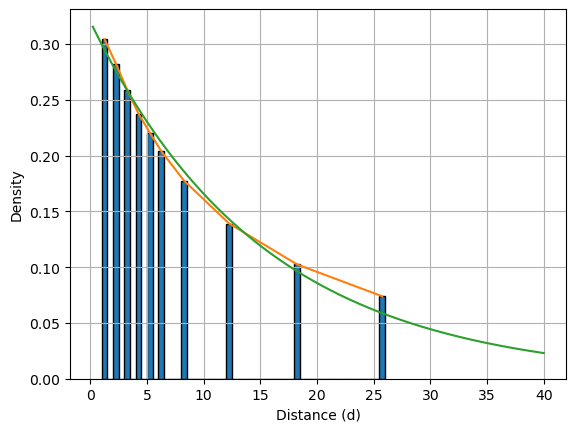

In [8]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit

def exp_decay(x,a,b):
    return b*np.exp(-a*x)

def volume_density_exp_decay(x,L):
    return (1/(2*(L**3)))*(x**2)*np.exp(-(x/L))

n, bins,_ = plt.hist(distances, bins=50, edgecolor='black',density = True)

print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

popt, pcov = curve_fit(exp_decay, xdata, ydata)

# distances_numpy = np.array(distances)
# kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(distances_numpy.reshape(-1, 1))
distances_plot = np.linspace(0.215, 40, 3979)
# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

density = exp_decay(distances_plot,*popt)

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))

print(density.sum()*(distances_plot[1]-distances_plot[0]))

print((distances_plot[1]-distances_plot[0]))

plt.plot(xdata,ydata)
plt.plot(distances_plot,density)
plt.xlabel('Distance (d)')
plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
np.save(f'{instr}_density.npy',density)
plt.grid()
plt.show()

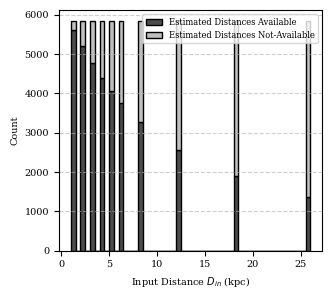

[[5617.    0. 5211.    0. 4780.    0. 4383.    0. 4070.    0. 3765.    0.
     0.    0. 3279.    0.    0.    0.    0.    0.    0.    0. 2566.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 1890.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0. 1364.]
 [5832.    0. 5832.    0. 5832.    0. 5832.    0. 5832.    0. 5832.    0.
     0.    0. 5832.    0.    0.    0.    0.    0.    0.    0. 5832.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 5832.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0. 5832.]]


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set MNRAS-compatible font and style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.titlesize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['legend.fontsize'] = 6

# Combine distances and na_distances into a list of datasets
data = [distances, na_distances]

# Create the histogram
fig, ax = plt.subplots(figsize=(10/3, 3))  # Suitable for single-column MNRAS format
counts, bins, _ = ax.hist(data, bins=50, edgecolor='black', stacked=True, 
        label=['Estimated Distances Available', 'Estimated Distances Not-Available'], 
        color=['#4d4d4d', '#bfbfbf'], alpha=1)

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Count', fontsize=7)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add a legend
ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/{instr}/stacked_histogram_distances_{instr}.pdf', dpi=600)

# Show the plot
plt.show()

print(counts)


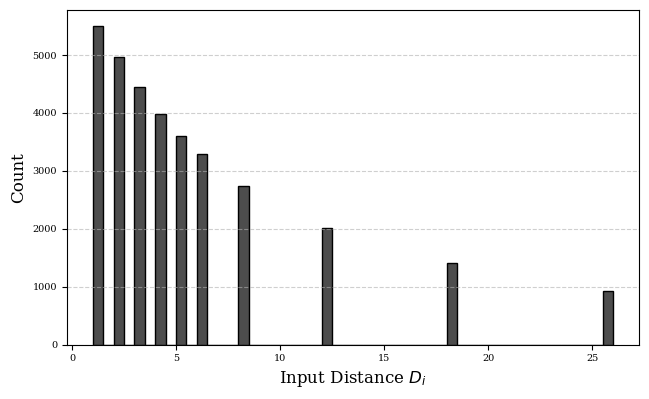

In [10]:
# Create the histogram
fig, ax = plt.subplots(figsize=(6.5, 4))  # Suitable for single-column MNRAS format
ax.hist(tight_distances, bins=50, edgecolor='black',color='#4d4d4d')

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_i$', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# # Add a legend
# ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/{instr}/constrained_distances_{instr}.pdf', dpi=600)

# Show the plot
plt.show()

Endpoints array x: [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  9.5 14.5 21.5 30.5]
Computed midpoints: [ 1.  2.  3.  4.  5.  6.  8. 12. 18. 26.]
[ 1.  2.  3.  4.  5.  6.  8. 12. 18. 26.]
[0.16730524 0.15094569 0.13513349 0.12099374 0.10959071 0.09998176
 0.02780312 0.01230311 0.00612071 0.00314217]
[ 0.16355998  0.31444677 -2.40048723]
mse: 0.0002187769524495863, fit function: <function exp_decay at 0x7fed3aa7f4c0>
[4.54743633 0.24806493 1.25569855]
mse: 0.00012735935387775838, fit function: <function weibull at 0x7fed3aa7fe20>
[ 5.50337594  0.51736538 -2.31581921]
mse: 0.000224703202000691, fit function: <function log_normal at 0x7fed3aa7f920>
[0.99999999 3.8431032 ]
mse: 0.000290199564100948, fit function: <function cauchy at 0x7fed3aa7fce0>
[ 1.71342622 -1.49330131]
mse: 0.00019185238214481897, fit function: <function volume_density_exp_decay at 0x7fed3aa7ff60>
lowest mse: 0.00012735935387775838, fit function: <function weibull at 0x7fed3aa7fe20>


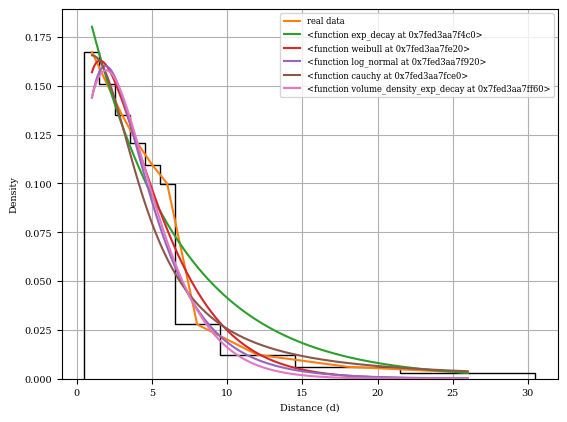

In [11]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.stats import pareto
from scipy.stats import lognorm
from scipy.stats import genpareto
from scipy.stats import weibull_min
from scipy.stats import exponweib
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.stats import halfcauchy
from scipy.stats import halfgennorm
from scipy.stats import powerlaw
from scipy.stats import genexpon

# Given midpoints array
m = np.array([1, 2, 3, 4, 5, 6, 8, 12, 18, 26])
n = m.size  # number of midpoints

# Allocate endpoints array (n+1 points)
x = np.empty(n + 1)

# Choose x[0] as described:
x[0] = m[0] - (m[1] - m[0]) / 2.0

# Use the recurrence relation:
for i in range(n):
    x[i + 1] = 2 * m[i] - x[i]

print("Endpoints array x:", x)

# Verify the midpoints:
m_computed = (x[:-1] + x[1:]) / 2.0
print("Computed midpoints:", m_computed)

def exp_decay(x,a,b,c):
    return b*np.exp(-a*(x-c))

def weibull(x,a,b,c):
    return weibull_min.pdf(x,c=c, loc=b, scale=a)

def power_law(x,a,b,c):
    return powerlaw.pdf(x, a, loc=b, scale=c)

def power_law_tail(x,a,b,c):
    return pareto.pdf(x, b=b, loc=c, scale=a)

def power_law_tail_gen(x,a,b,c,d):
    return genpareto.pdf(x, c=c, loc=b, scale=a)+d

def log_normal(x,a,b,c):
    return lognorm.pdf(x, s=b, loc=c, scale=a)

def cauchy(x,a,b):
    return halfcauchy.pdf(x, loc=a, scale=b)

def volume_density_exp_decay(x,L,c):
    return (1/(2*(L**3)))*((x-c)**2)*np.exp(-((x-c)/L))

def half_gen_normal(x,a,b,c):
    return halfgennorm.pdf(x, beta=b, loc=a, scale=c)

def gen_expon(x,a,b,c,d,e):
    return genexpon.pdf(x, a, b, c, loc=d, scale=e)

n, bins,_ = plt.hist(tight_distances, bins= x, edgecolor='black',density = True,histtype="step")

# print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

print(xdata)
print(ydata)

distances_plot = np.linspace(1, 26, 10000)

# f_interp = interp1d(xdata, ydata, kind='cubic')
# f_interp = UnivariateSpline(xdata, ydata, s=0)

# ydata = f_interp(distances_plot)
# xdata = distances_plot

# fit_func_list = [log_normal]
fit_func_list = [exp_decay,weibull,log_normal,cauchy,volume_density_exp_decay]
mse_list = []
best_fit_param_list = []

for fit_func in fit_func_list:

    popt, pcov = curve_fit(fit_func, xdata, ydata)

    print(popt)

    best_fit_param_list.append(popt)

    mse = np.mean( (ydata - fit_func(xdata,*popt))**2 )

    mse_list.append(mse)

    print(f"mse: {mse}, fit function: {fit_func}")

mse_list = np.array(mse_list)
print(f"lowest mse: {mse_list.min()}, fit function: {fit_func_list[mse_list.argmin()]}")
best_function = fit_func_list[mse_list.argmin()]

distances_numpy = np.array(tight_distances)
# kde = KernelDensity(kernel='exponential', bandwidth=5).fit(distances_numpy.reshape(-1, 1))

# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))



plt.plot(xdata,ydata,label="real data")
for i,fit_func in enumerate(fit_func_list):
    density = fit_func(distances_plot,*best_fit_param_list[i])
    plt.plot(distances_plot,density,label=str(fit_func))
    plt.xlabel('Distance (d)')
    plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
# np.save(f'{instr}_density.npy',density)
plt.legend()
plt.grid()
plt.show()

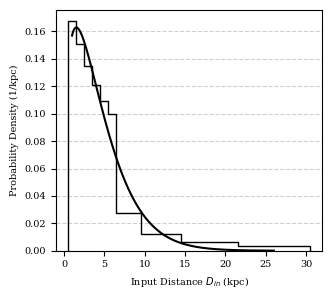

0.0000633980127947490708145358850877926215616753324866294860839843750000000000000000000000000000000000


In [12]:
density = best_function(distances_plot,*best_fit_param_list[mse_list.argmin()])

# Create the histogram
fig, ax = plt.subplots(figsize=(10/3, 3))  # Suitable for single-column MNRAS format
plt.plot(distances_plot,density,"k-",label="Best-fit")
ax.hist(tight_distances, bins=x, edgecolor='black',color='#4d4d4d',density=True,histtype="step")

# Set labels and title with LaTeX formatting
ax.set_xlabel(r'Input Distance $D_{in}$ (kpc)', fontsize=7)
ax.set_ylabel('Probability Density (1/kpc)', fontsize=7)
# ax.set_title('Stacked Histogram of Distances', fontsize=14)

# Add a grid with dashed lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# # Add a legend
# ax.legend()

# Adjust layout for clarity
plt.tight_layout()

# Save the figure in a high-resolution format suitable for publication
plt.savefig(f'plots/{instr}/constrained_distances_{instr}_density.pdf', dpi=600)

# Show the plot
plt.show()

print('%.100f' % best_function(26,*best_fit_param_list[mse_list.argmin()]))

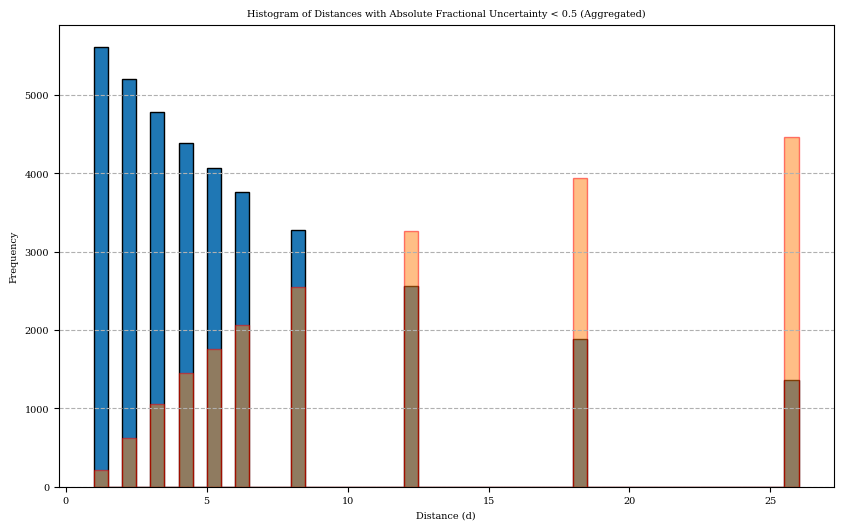

In [13]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black')
plt.hist(na_distances, bins=50, edgecolor='red', alpha=0.5, label='Non-Available Distances')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

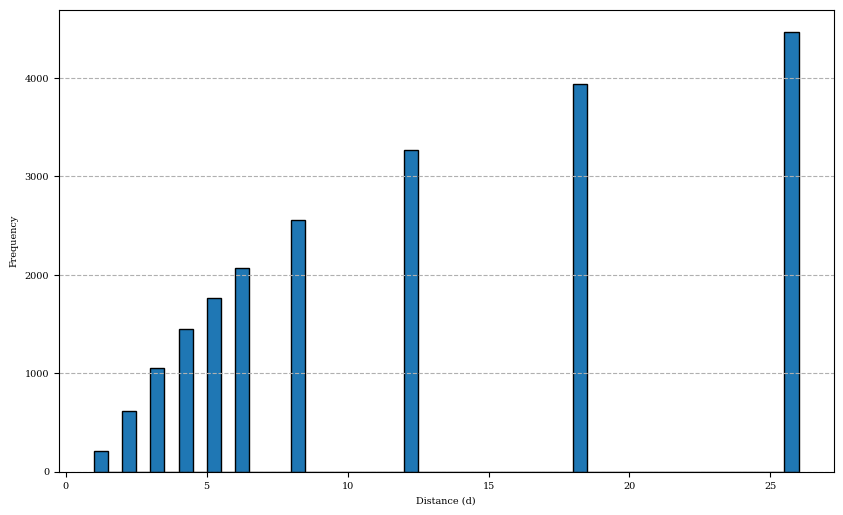

In [14]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(na_distances, bins=50, edgecolor='black')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

# Aggregation of data

/tmp/ipykernel_1895851/4222230849.py:5: FutureWarning: The provided callable <function median at 0x7fed944602c0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)


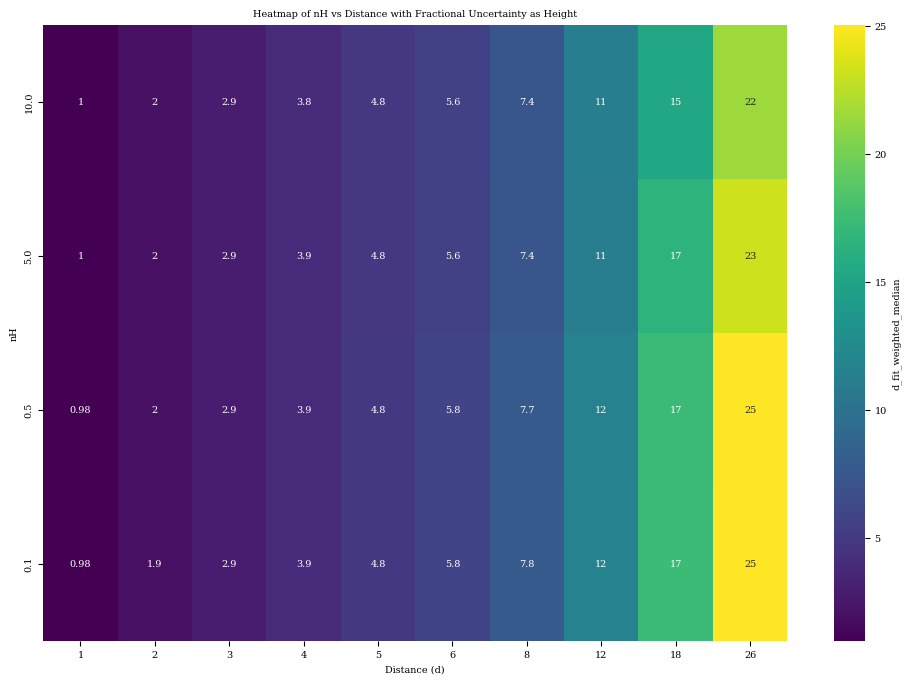

In [15]:
# Concatenate all the data into a single DataFrame
aggregated_data = pd.concat(all_data, ignore_index=True)

# Create a pivot table for the heatmap
heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values=central_value, aggfunc=np.median)

# Sort the index (nH) in ascending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, cbar_kws={'label': central_value})
plt.xlabel('Distance (d)') 
plt.ylabel('nH')
plt.title('Heatmap of nH vs Distance with Fractional Uncertainty as Height')
plt.show()


# nH by distance grid plot

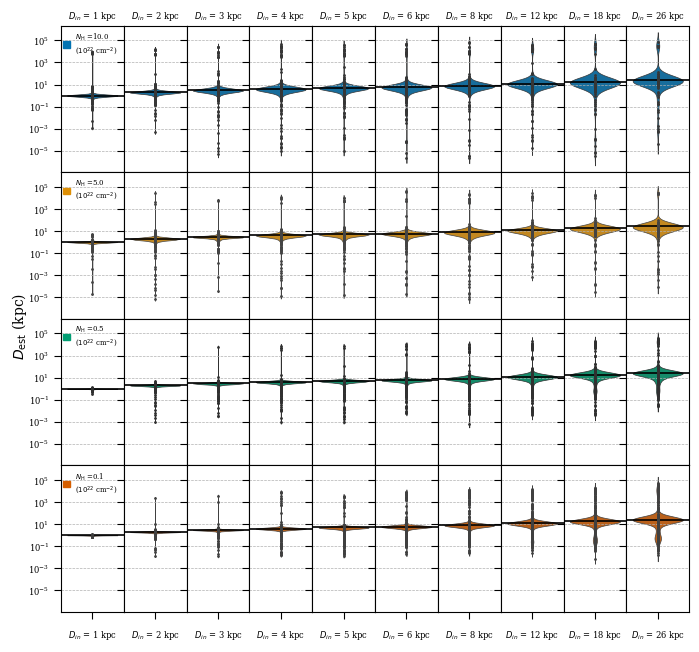

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Group the data by 'nH' and 'd'
grouped_data = aggregated_data.groupby(['nH', 'd'])

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique(), reverse=True) 
d_values = sorted(aggregated_data['d'].unique())

# Create a color palette for nH values
palette = sns.color_palette("colorblind", len(nH_values))  # Adjust palette as needed
nH_colors = {nH: color for nH, color in zip(nH_values, palette)}

# Adjust figure size to fit MNRAS page dimensions
fig_width = 6.974  # MNRAS page width in inches
fig_height_per_row = 1.8  # Adjusted height per row
fig_height = fig_height_per_row * len(nH_values)

fig, axes = plt.subplots(
    len(nH_values), len(d_values),
    figsize=(fig_width, fig_height),
    sharex=True, sharey=True,  # Share x and y axes
    gridspec_kw={'wspace': 0, 'hspace': 0}  # Overlap axes
)

# Get global y-axis limits
all_d_fit_values = aggregated_data[central_value]
# ymin, ymax = all_d_fit_values.min(), all_d_fit_values.max()

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        ax = axes[i, j]

        # Get the distribution of d_fit for each combination of nH and d
        subset = grouped_data.get_group((nH, d))[central_value] if (nH, d) in grouped_data.groups else []
        
        ax.set_yscale('log')
        
        if len(subset) > 0:
            sns.violinplot(y=subset, ax=ax, inner="point",color=nH_colors[nH], linewidth=0.5)  # Use the color for the current nH)
        
        # Reduce grid lines to only major ticks on the y-axis
        ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

        # Set consistent y-axis limits
        # ax.set_ylim(ymin, ymax)

        # Remove the default y-label
        ax.set_ylabel("")

        # Horizontal line for reference
        ax.axhline(y=d_values[j], color="black", linestyle='-', linewidth=1.2)

        # Set titles and labels
        if i == 0:
            ax.set_title(r"$D_{in}$ =" + f" {d} kpc", fontsize=6, pad=5)  # Font size adjusted
        # if j == 0:
        #     ax.set_ylabel(f"$N_H = {nH}$", fontsize=7, labelpad=2)  # Reduced padding

        if j == 0:  # Only add label once per row
            # ax.text(0.05, 0.95, f"Input $N_H$ = {nH}", transform=ax.transAxes,
                    # fontsize=5, verticalalignment='top', horizontalalignment='left',
                    # bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.3))

            # Add a small legend inside the "Input $N_H$" box
            legend_handle = mpatches.Patch(color=nH_colors[nH], label=r"$N_\text{H}$ =" + f"{nH}\n" + r"($10^{22}$ cm$^{-2}$)")
            ax.legend(
                handles=[legend_handle],
                loc='upper right',
                fontsize=5,
                frameon=False,
                handlelength=1,
                handleheight=1
            )
            
        # Add x-axis labels for the bottom row
        if i == len(nH_values) - 1:
            ax.set_xlabel(r"$D_{in}$ =" + f" {d} kpc", fontsize=6)
            ax.tick_params(axis='x', rotation=45)  # Rotate x-labels

        # Customize ticks
        ax.tick_params(axis='both', which='major', labelsize=6, length=5, width=0.8)
        ax.tick_params(axis='both', which='minor', labelsize=6, length=3, width=0.5)

# Shared ylabel positioned closer to the subplots
fig.text(0.015, 0.5,r"$D_{\text{est}}$ (kpc)", va='center', rotation='vertical', fontsize=10)

# Adjust layout to ensure no text overlap
plt.tight_layout(pad=0.8, rect=[0.03, 0.05, 1, 0.95])

# Save the figure as a high-resolution PDF
plt.savefig(f"plots/{instr}/2d_violin_plot_{instr}.png", dpi=600, bbox_inches='tight')
plt.show()


# Main effect plots

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$M$ ($M_{\odot}$)",               # Mass in solar masses
    'i': r"$i$ (degrees)",                   # Inclination in degrees
    'r': r"Disk-to-total flux ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)"                   # Exposure in seconds
}

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
    # Repeat the parameter dictionary for each row in the corresponding data_df
    params_df = pd.DataFrame([params] * len(data_df))
    # Concatenate data and parameters
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Define the parameters to aggregate by
parameters = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    if param == 'g' or param == 'm':
        
        # Create subplots for the current parameter
        fig, axes = plt.subplots(
            len(param_values), 1,
            figsize=(3.3, len(param_values) * 1.2),  # Single-column layout
            sharex=True,
            sharey=True
        )
    else:
        # Create subplots for the current parameter
        fig, axes = plt.subplots(
            len(param_values), 1,
            figsize=(3.3, len(param_values) * 2.2),  # Single-column layout
            sharex=True,
            sharey=True
        )

    # Set vertical spacing between subplots to zero
    plt.subplots_adjust(hspace=0)  # No vertical space between panels

    # Iterate through each parameter value and plot distributions
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()

        if not subset.empty:
            subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
            ax.set_yscale('log')  # Use log scale for y-axis
            palette = sns.color_palette('colorblind', len(d_values))  # Colorblind-friendly palette
            sns.violinplot(
                data=subset,
                x='d',
                y=central_value,
                ax=ax,
                hue='d',  # Assign hue to the same as x-axis
                inner=None,  # No internal marks
                palette=palette,
                linewidth=0.3,  # Reduced line width for clarity
                legend=False  # Suppress legend
            )

            # Dynamically calculate the true x-axis limits after padding
            x_limits = ax.get_xlim()
            x_left = x_limits[0]  # True left edge of the axis
            for d_idx, d_value in enumerate(d_values):
                # Get subset of data for the current `d_value`
                data_d_value = subset.loc[subset['d'] == str(d_value), central_value]
                if not data_d_value.empty:
                    x_max = d_idx + 0.3  # Slightly after the violin's center
                    ax.plot([x_left, x_max], [d_value, d_value], color=palette[d_idx], linestyle='-', linewidth=0.5)

        # Add titles inside the panel using parameter_labels
        ax.text(
            0.02, 0.95, f"{parameter_labels[param]} = {val}",
            transform=ax.transAxes, fontsize=7, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.2)
        )

        # Add y-axis label for each subplot
        ax.set_ylabel(r"$D_{\text{est}}$ (kpc)", fontsize=7, labelpad=2)

        # Add grid lines for better readability
        ax.grid(True, which='major', linestyle=':', linewidth=0.3)

        # Adjust tick size to match label font size
        ax.tick_params(axis='both', which='major', labelsize=7, length=3, width=0.3)
        ax.tick_params(axis='both', which='minor', labelsize=7, length=2, width=0.3)

        # Adjust the y-axis ticks explicitly for log scaling
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))  # Max 5 major ticks
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto", numticks=10))  # Minor ticks
        ax.set_xlim(x_limits)

    # Add x-axis label only for the bottom plot
    axes[-1].set_xlabel(r"$D_{\text{in}}$ (kpc)", fontsize=7)

    # Adjust layout to ensure no overlaps and save the figure
    plt.tight_layout(pad=0.0)
    plt.savefig(f"plots/{instr}/{param}_violin_plot_{instr}.png", dpi=600, bbox_inches='tight')
    plt.close(fig)


# Interaction effects plots

In [21]:
import glob
from collections import defaultdict

##############################################################################
# 1) Collect all CSV files from "effects_data_{instr}/effect_*.csv"
##############################################################################
all_csv_files = sorted(glob.glob(f"effects_data_{instr}/effect_*.csv"))

file_effects = []
for csv_file in all_csv_files:
    base_name = os.path.basename(csv_file)
    effect_name = re.sub(r'^effect_|\.csv$', '', base_name)
    # Convert underscores to colons, e.g. "m_r" -> "m:r"
    effect_name = effect_name.replace('_', ':')
    
    file_effects.append((csv_file, effect_name))

n_total = len(file_effects)
print(f"\n===== Found {n_total} total interaction CSVs =====")
for csv_path, eff in file_effects:
    print(f"  - {eff} from {os.path.basename(csv_path)}")

##############################################################################
# 2) Group interactions by the first variable
##############################################################################
grouped_effects = defaultdict(list)

for csv_file, effect_name in file_effects:
    first_var = effect_name.split(':')[0]
    grouped_effects[first_var].append((csv_file, effect_name))

# Convert grouped effects to a list of chunks
chunks = list(grouped_effects.values())

##############################################################################
# 3) Parameter labels (LaTeX-friendly)
##############################################################################
parameter_labels = {
    'g':  r"$\Gamma$",
    'T':  r"$T$ (keV)",
    'a':  r"$a$",
    'm':  r"$m$ ($M_{\odot}$)",
    'i':  r"$i$ ($^\circ$)",
    'r':  r"Disk-to-total ratio",
    'e':  r"Exposure (sec)",
    'd':  r"$D$ (kpc)",
    'nH': r"$N_H$ ($\times 10^{22} cm^{-2}$)"
}

##############################################################################
# 4) Helper: Sort categories numerically if possible
##############################################################################
def sort_as_numeric_if_possible(values):
    """
    Attempt to parse each string in `values` as float.
    If successful, sort numerically. Otherwise, sort lexically.
    Returns a list of sorted strings.
    """
    unique_vals = list(set(values))
    try:
        float_vals = [float(v) for v in unique_vals]
        float_vals.sort()
        # Convert back to string
        return [str(v) for v in float_vals]
    except ValueError:
        # Fallback lexical sort
        return sorted(unique_vals, key=str)

##############################################################################
# 5) The main plotting function for one interaction
##############################################################################
def plot_interaction(ax, csv_file, effect_name, param_labels):
    print(f"Plotting: {effect_name} from {os.path.basename(csv_file)}")

    vars_in_effect = effect_name.split(':')
    if len(vars_in_effect) != 2:
        print(f"  Skipping: '{effect_name}' does not have exactly 2 vars.")
        ax.set_visible(False)
        return

    xvar, groupvar = vars_in_effect

    # Read CSV
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"  Skipping: {csv_file} is empty.")
        ax.set_visible(False)
        return

    needed_cols = {xvar, groupvar, "fit", "lower", "upper"}
    if not needed_cols.issubset(df.columns):
        print(f"  Skipping: missing columns. Need {needed_cols}, have {df.columns}")
        ax.set_visible(False)
        return

    # -----------------------------------------------------------------------
    # A) Convert xvar to numeric, unify format as string (so '0' -> '0.0')
    # -----------------------------------------------------------------------
    df[xvar] = pd.to_numeric(df[xvar], errors="coerce").round(2)
    df[xvar] = df[xvar].apply(lambda x: f"{x:.1f}" if pd.notnull(x) else None)
    df = df.dropna(subset=[xvar])
    if df.empty:
        print(f"  Skipping: all xvar are NaN after conversion.")
        ax.set_visible(False)
        return

    # -----------------------------------------------------------------------
    # B) Sort xvar categories numerically if possible
    # -----------------------------------------------------------------------
    xcats = sort_as_numeric_if_possible(df[xvar])
    print(f"   xvar categories sorted: {xcats}")
    if not xcats:
        print("  No valid x categories after conversion.")
        ax.set_visible(False)
        return

    # Map category -> integer position
    xmapping = {cat: i for i, cat in enumerate(xcats)}

    # -----------------------------------------------------------------------
    # C) Convert groupvar to string, sort legend levels numerically if possible
    # -----------------------------------------------------------------------
    df[groupvar] = df[groupvar].astype(str)
    group_candidates = list(sorted(set(df[groupvar])))

    try:
        sorted_groups_float = sorted(group_candidates, key=lambda x: float(x))
        sorted_groups = sorted_groups_float
    except ValueError:
        # Fallback to lexical
        sorted_groups = sorted(group_candidates)

    print("   groupvar levels sorted:", sorted_groups)

    # -----------------------------------------------------------------------
    # D) Plot each group as a line + error bars on a categorical x-axis
    # -----------------------------------------------------------------------
    cmap = plt.colormaps.get_cmap("tab10")
    colors = [cmap(i) for i in range(len(sorted_groups))]
    linestyles = ["-", "--", ":", "-."]

    # Step 1: Split effect_name by ':'
    effect_parts = effect_name.split(':')

    # Step 2: For each part, look up in parameter_labels. If not found, fallback to raw string
    replaced_parts = []
    for part in effect_parts:
        replaced_parts.append(parameter_labels.get(part, part).split(" (")[0])


    # Step 3: Re-join them, maybe with ' × ' (or any delimiter)
    nice_label = " by ".join(replaced_parts)

    for linestyle, color, grp_value in zip(linestyles, colors, sorted_groups):
        subset = df[df[groupvar] == grp_value]
        xvals = [xmapping[val] for val in subset[xvar]]
        ax.plot(xvals, np.exp(subset["fit"])*100, 'o', color=color, linestyle=linestyle, markersize=3, label=grp_value)
        ax.errorbar(xvals, np.exp(subset["fit"])*100, yerr=[(np.exp(subset["fit"]) - np.exp(subset["lower"]))*100, (np.exp(subset["upper"]) - np.exp(subset["fit"]))*100],
                    fmt='none', ecolor=color, capsize=3, label="_nolegend_")

    ax.set_xticks(range(len(xcats)))
    ax.set_xticklabels(xcats, rotation=0)
    ax.set_xlabel(param_labels.get(xvar, xvar), fontsize=8)
    ax.legend(fontsize=6, title=param_labels.get(groupvar, groupvar), loc="best",title_fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6, length=3, width=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.set_title(nice_label,fontsize=9)

##############################################################################
# 6) A helper to plot one "chunk" of interactions in a figure
##############################################################################
def plot_chunk(chunk, figure_index, param_labels):
    n_subplots = len(chunk)
    if n_subplots % 2 == 0:
        n_cols = 2
    else:
        n_cols = n_subplots
    n_rows = (n_subplots + 1) // n_cols


    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6.6, 2.0 * n_rows), sharex=False, sharey=False)
    axes = axes.flatten() if n_subplots > 1 else [axes]

    for i, (csv_file, effect_name) in enumerate(chunk):
        plot_interaction(axes[i], csv_file, effect_name, param_labels)

    for leftover in range(len(chunk), len(axes)):
        axes[leftover].set_visible(False)
    
    fig.text(-0.02, 0.5, r'$\frac{|\Delta D_{\text{est,in}}|}{D_{\text{in}}}$' + f"(%)", va='center', rotation='vertical', fontsize=9)
    plt.tight_layout()

    # If you want to save each figure
    out_file = f"plots/{instr}/effects_figure_{figure_index}.png"
    plt.savefig(out_file, dpi=600, bbox_inches="tight")

    plt.show()

##############################################################################
# 7) Plot each group
##############################################################################
for i, chunk in enumerate(chunks, start=1):
    print(f"=== Plotting Group {i} ({len(chunk)} interactions) ===")
    plot_chunk(chunk, i, parameter_labels)



===== Found 0 total interaction CSVs =====


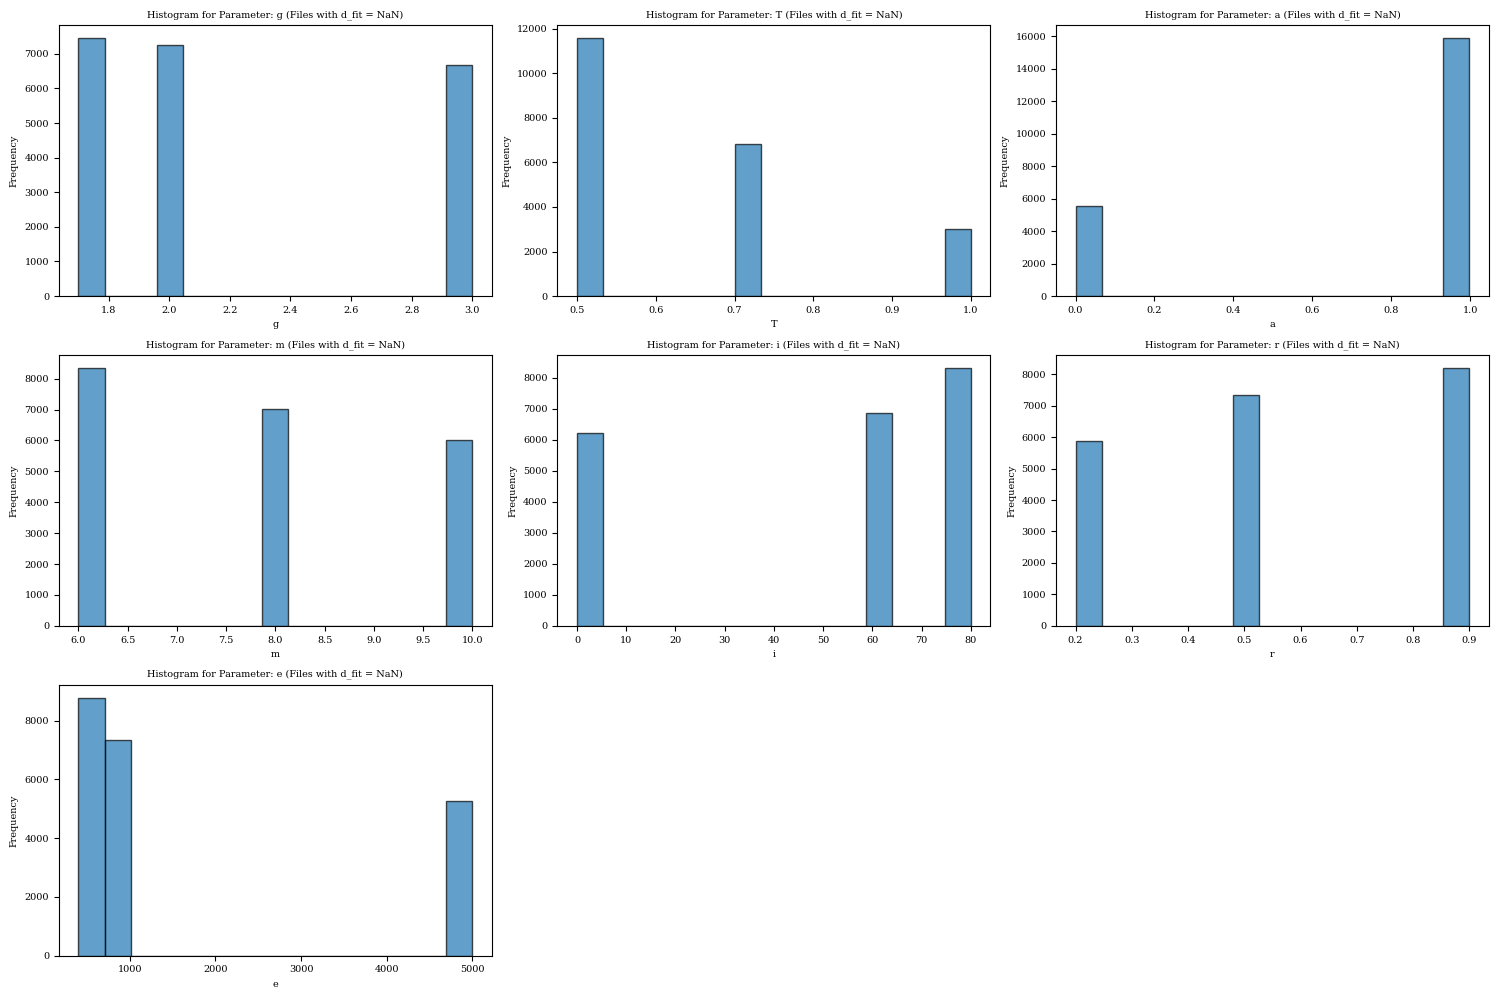

In [24]:
# Plot histograms for each parameter in files that have 'd_fit' = NaN
plt.figure(figsize=(15, 10))
parameter_names = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Iterate over parameters and plot histograms in a 2x3 layout
for idx, param_name in enumerate(parameter_names[:7]):  # Only using the first 6 parameters for the 2x3 layout
    values = [params[param_name] for params in na_d_fit_params if param_name in params]
    plt.subplot(3, 3, idx + 1)
    plt.hist(values, bins=15, edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Parameter: {param_name} (Files with d_fit = NaN)')

plt.tight_layout()
plt.show()

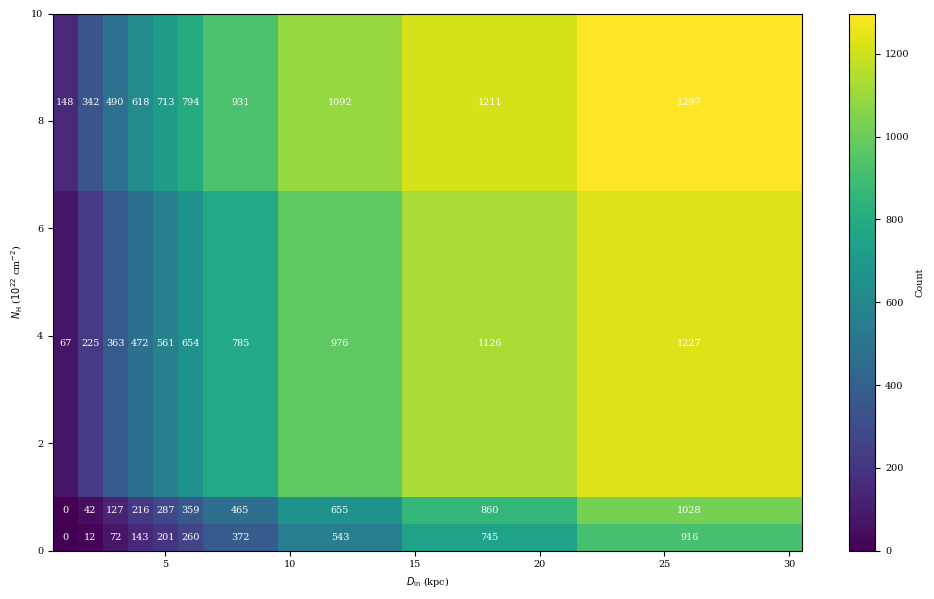

In [23]:
# Define bin edges
x_bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,9.5,14.5,21.5,30.5]
y_bins = [0, 0.5,1, 6.7, 10]

# Plot a 2D histogram for 'nH' and 'd' of non-available distances
plt.figure(figsize=(10, 6))
hist, x_edges, y_edges, im = plt.hist2d(na_distances, na_nH, bins=(x_bins, y_bins), cmap='viridis')
plt.ylabel(r'$N_\text{H}$ ($10^{22}$ cm$^{-2}$)')
plt.xlabel(r'$D_{\text{in}}$ (kpc)')
plt.colorbar(label='Count')

# Annotate counts on the cells
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        count = hist[i, j]
        # if count > 0:  # Only annotate non-empty bins
        plt.text((x_edges[i] + x_edges[i + 1]) / 2,
                    (y_edges[j] + y_edges[j + 1]) / 2,
                    int(count),
                    ha='center', va='center', color='white')

plt.tight_layout()
plt.show()